In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


In [4]:
DEVICE = "cude" if torch.cuda.is_available() else "cpu"

print(f'Using device {DEVICE}')

Using device cpu


In [7]:
img_size = 32
batch_size = 128

transforms = v2.Compose([
    v2.Resize((img_size, img_size)), # resize to 32*32
    v2.ToTensor(),
    v2.Lambda(lambda t:(t*2)-1) # change all the grid values into the range [-1.0, 1.0]
    ])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)




100%|██████████| 170M/170M [03:29<00:00, 816kB/s]    


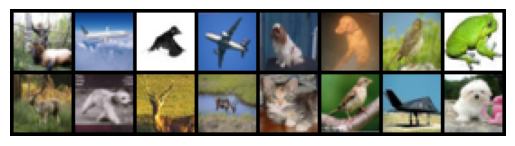

In [9]:
def show_img(images, title=""):
    images = (images+1) /2
    images = images.clamp(0, 1)

    grid_img = torchvision.utils.make_grid(images, nrow = 8)
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()


image_batch , _= next(iter(dataloader))
show_img(image_batch[:16])

In [14]:
timestamps = 300

def linear_beta_schedule(timestamps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timestamps)

betas = linear_beta_schedule(timestamps=timestamps) # this is variance schedule, defines amt of noise that is added till the timestamps

# alp = 1. - betas # amt of image content remain
# alphae_cumprod =  torch.cumprod(alp, axis=0) # total amt of image content/signal left after t-steps

# sqrt_alp_cumprod = torch.sqrt(alphae_cumprod)
# sqrt_one_minus_alp_cumprod = torch.sqrt(1. - alphae_cumprod)


alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_i_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,)*(len(x_shape)-1))).to(t.device)

def forward_diff_sample(x_0, t, device=DEVICE):
    noise = torch.randn_like(x_0)  # random noise with normal distribution

    # sqrt(alpha_cumprod) and sqrt(1 - alpha_cumprod) for the given timestep t
    sqrt_alphas_cumprod_t = get_i_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_i_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    # Calculate the noisy image
    # mean + variance * noise
    noisy_image = (sqrt_alphas_cumprod_t.to(device)*x_0.to(device)) + (sqrt_one_minus_alphas_cumprod_t.to(device)*noise.to(device))
    
    return noisy_image, noise



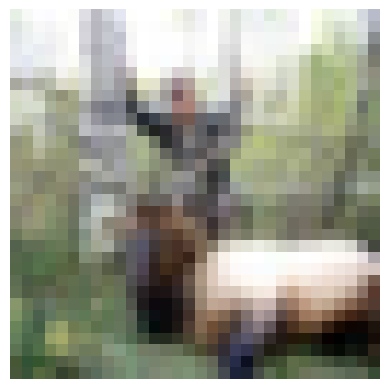

In [17]:
show_img(image_batch[0])

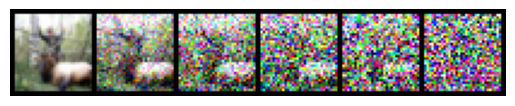

In [15]:
single_image = image_batch[0].unsqueeze(0)

# Define timesteps to visualize
timesteps_to_show = [0, 50, 100, 150, 199, 299]
noisy_images = []

# Generate noisy versions of the image at different timesteps
for t_val in timesteps_to_show:
    t = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diff_sample(single_image, t)
    noisy_images.append(noisy_img)

# Concatenate for visualization
noisy_images_tensor = torch.cat(noisy_images, dim=0)

# Show the results
show_img(noisy_images_tensor)


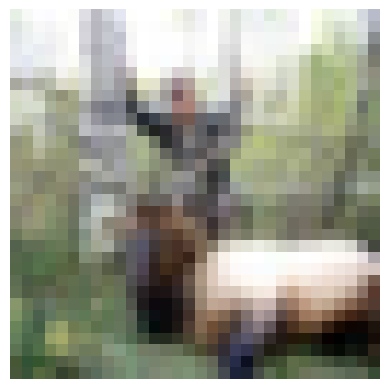

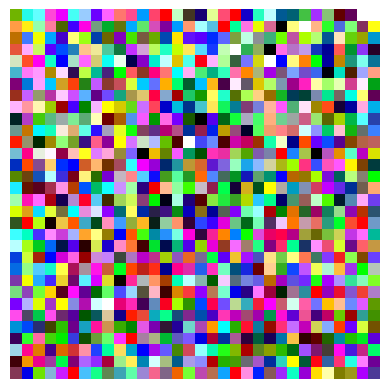

(None, None)

In [21]:
show_img(image_batch[0]), show_img(noisy_img)